# 第11回講義 演習

In [1]:
%matplotlib inline

import os

import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

rng = np.random.RandomState(1234)
random_state = 42

Using TensorFlow backend.


## 課題1. Attentionを用いた機械翻訳モデルの実装

### 1. データセットの読み込みと単語・品詞のID化

Chap10と同様Tanaka Corpusの一部を抽出したデータセット (https://github.com/odashi/small_parallel_enja) を使います.

In [2]:
def build_vocab(file_path, target):
    vocab = set()
    for line in open(file_path, encoding='utf-8'):
        words = line.strip().split()
        vocab.update(words)

    if target:
        w2i = {w: np.int32(i+2) for i, w in enumerate(vocab)}
        w2i['<s>'], w2i['</s>'] = np.int32(0), np.int32(1) # 文の先頭・終端記号
    else:
        w2i = {w: np.int32(i) for i, w in enumerate(vocab)}

    return w2i

def encode(sentence, w2i):
    encoded_sentence = []
    for w in sentence:
        encoded_sentence.append(w2i[w])
    return encoded_sentence

def load_data(file_path, vocab=None, w2i=None, target=True):
    if vocab is None and w2i is None:
        w2i = build_vocab(file_path, target)
    
    data = []
    for line in open(file_path, encoding='utf-8'):
        s = line.strip().split()
        if target:
            s = ['<s>'] + s + ['</s>']
        enc = encode(s, w2i)
        data.append(enc)
    i2w = {i: w for w, i in w2i.items()}
    return data, w2i, i2w

In [3]:
# 出力系列にのみ'<s>', '</s>'をつける
train_X, e_w2i, e_i2w = load_data('train.en', target=False)
train_y, j_w2i, j_i2w = load_data('train.ja', target=True)

train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=0.1, random_state=random_state)
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.1, random_state=random_state)

In [4]:
train_X_lens = [len(com) for com in train_X]
valid_X_lens = [len(com) for com in valid_X]
sorted_train_indexes = sorted(range(len(train_X_lens)), key=lambda x: -train_X_lens[x])
sorted_valid_indexes = sorted(range(len(valid_X_lens)), key=lambda x: -valid_X_lens[x])

train_X = [train_X[ind] for ind in sorted_train_indexes]
train_y = [train_y[ind] for ind in sorted_train_indexes]
valid_X = [valid_X[ind] for ind in sorted_valid_indexes]
valid_y = [valid_y[ind] for ind in sorted_valid_indexes]

### 2. 各層クラスの実装

Embedding, LSTM, DenseクラスはChap10で用いたものと同じです.

In [5]:
class Embedding:
    def __init__(self, vocab_size, emb_dim, scale=0.08):
        self.V = tf.Variable(rng.randn(vocab_size, emb_dim).astype('float32') * scale, name='V')

    def f_prop(self, x):
        return tf.nn.embedding_lookup(self.V, x)
    
    def f_prop_test(self, x_t):
        return tf.nn.embedding_lookup(self.V, x_t)

In [6]:
class LSTM:
    def __init__(self, in_dim, hid_dim, m, h_0=None, c_0=None):
        self.in_dim = in_dim
        self.hid_dim = hid_dim

        # input gate
        self.W_xi = tf.Variable(tf.random_uniform([in_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_xi')
        self.W_hi = tf.Variable(tf.random_uniform([hid_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_hi')
        self.b_i  = tf.Variable(tf.random_uniform([hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='b_i')
        
        # forget gate
        self.W_xf = tf.Variable(tf.random_uniform([in_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_xf')
        self.W_hf = tf.Variable(tf.random_uniform([hid_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_xf')
        self.b_f  = tf.Variable(tf.random_uniform([hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='b_f')

        # output gate
        self.W_xo = tf.Variable(tf.random_uniform([in_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_xo')
        self.W_ho = tf.Variable(tf.random_uniform([hid_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_ho')
        self.b_o  = tf.Variable(tf.random_uniform([hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='b_o')

        # cell state
        self.W_xc = tf.Variable(tf.random_uniform([in_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_xc')
        self.W_hc = tf.Variable(tf.random_uniform([hid_dim, hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='W_hc')
        self.b_c  = tf.Variable(tf.random_uniform([hid_dim], minval=-0.08, maxval=0.08, dtype=tf.float32), name='b_c')

        # initial state
        self.h_0 = h_0
        self.c_0 = c_0

        # mask
        self.m = m

    def f_prop(self, x):
        def fn(tm1, x_and_m):
            h_tm1 = tm1[0]
            c_tm1 = tm1[1]
            x_t = x_and_m[0]
            m_t = x_and_m[1]
            # input gate
            i_t = tf.nn.sigmoid(tf.matmul(x_t, self.W_xi) + tf.matmul(h_tm1, self.W_hi) + self.b_i)

            # forget gate
            f_t = tf.nn.sigmoid(tf.matmul(x_t, self.W_xf) + tf.matmul(h_tm1, self.W_hf) + self.b_f)

            # output gate
            o_t = tf.nn.sigmoid(tf.matmul(x_t, self.W_xo) + tf.matmul(h_tm1, self.W_ho) + self.b_o)

            # cell state
            c_t = f_t * c_tm1 + i_t * tf.nn.tanh(tf.matmul(x_t, self.W_xc) + tf.matmul(h_tm1, self.W_hc) + self.b_c)
            c_t = m_t[:, np.newaxis] * c_t + (1. - m_t[:, np.newaxis]) * c_tm1 # Mask

            # hidden state
            h_t = o_t * tf.nn.tanh(c_t)
            h_t = m_t[:, np.newaxis] * h_t + (1. - m_t[:, np.newaxis]) * h_tm1 # Mask

            return [h_t, c_t]

        _x = tf.transpose(x, perm=[1, 0, 2])
        _m = tf.transpose(self.m)

        if self.h_0 == None:
            self.h_0 = tf.matmul(x[:, 0, :], tf.zeros([self.in_dim, self.hid_dim]))
        if self.c_0 == None:
            self.c_0 = tf.matmul(x[:, 0, :], tf.zeros([self.in_dim, self.hid_dim]))

        h, c = tf.scan(fn=fn, elems=[_x, _m], initializer=[self.h_0, self.c_0])
        return tf.transpose(h, perm=[1, 0, 2]), tf.transpose(c, perm=[1, 0, 2])
    
    def f_prop_test(self, x_t):
        # input gate
        i_t = tf.nn.sigmoid(tf.matmul(x_t, self.W_xi) + tf.matmul(self.h_0, self.W_hi) + self.b_i)

        # forget gate
        f_t = tf.nn.sigmoid(tf.matmul(x_t, self.W_xf) + tf.matmul(self.h_0, self.W_hf) + self.b_f)

        # output gate
        o_t = tf.nn.sigmoid(tf.matmul(x_t, self.W_xo) + tf.matmul(self.h_0, self.W_ho) + self.b_o)

        # cell state
        c_t = f_t * self.c_0 + i_t * tf.nn.tanh(tf.matmul(x_t, self.W_xc) + tf.matmul(self.h_0, self.W_hc) + self.b_c)

        # hidden state
        h_t = o_t * tf.nn.tanh(c_t)

        return [h_t, c_t]

In [7]:
class Dense:
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        # Xavier
        self.W = tf.Variable(rng.uniform(
                        low=-np.sqrt(6/(in_dim + out_dim)),
                        high=np.sqrt(6/(in_dim + out_dim)),
                        size=(in_dim, out_dim)
                    ).astype('float32'), name='W')
        self.b = tf.Variable(tf.zeros([out_dim], dtype=tf.float32), name='b')
        self.function = function

    def f_prop(self, x):
        return self.function(tf.einsum('ijk,kl->ijl', x, self.W) + self.b)

    def f_prop_test(self, x_t):
        return self.function(tf.matmul(x_t, self.W) + self.b)

#### 2.1. Attention層

今回は Luong et al., 2015のGlobal attentionモデルを実装します.

- "Effective Approaches to Attention-based Neural Machine Translation", Minh-Thang Luong et al., EMNLP 2015 https://arxiv.org/abs/1508.04025

前回のchap10で実装したモデルは左図, 今回実装するモデルは右図になります.

<img src="./attention-1.png" width="1000mm">

#### Decoderの各ステップにおける計算の手順

Encoderの各ステップの隠れ層を

$$
    \bar{h} = \{\bar{h}_1, \bar{h}_2, \ldots, \bar{h}_s, \ldots, \bar{h}_S\}
$$

Decoderの各ステップの隠れ層を

$$
    h = \{h_1, h_2, \ldots, h_t, \ldots, h_T\}
$$

とします.

Attention Layerの計算手順は以下のようになります.

1. まずRNN (or LSTM, GRU, etc.) により, 隠れ層ベクトルを計算します.
$$
    h_t = \mathrm{RNN}(h_{t-1}, x_t)
$$
2. 次に, 入力系列のどのステップに注目するのかの**重み**$a_t(s)$を, score関数 (後述) により計算します.
$$
    a_t(s) = \frac{\exp(\mathrm{score}(\bar{h}_s, h_t))}{\sum^S_{s'=1}\exp(\mathrm{score}(\bar{h}_s, h_t))}
$$
3. 2.で計算した重みをもとに, Encoderの各ステップの隠れ層に対する重み付き平均ベクトル (**文脈ベクトル**) $c_t$ を計算します.
$$
    c_t = \sum^S_{s=1} a_t(s) \bar{h}_s
$$
4. 3.で計算した文脈ベクトルと1.で計算した隠れ層ベクトルから, 新しい出力ベクトルを計算します.
$$
    \tilde{h}_t = \tanh(W_h h_t + W_c c_t + b)
$$
5. 新しい出力ベクトル$\tilde{h}_t$をもとに各単語の出力確率を計算します.
$$
    y_t = \mathrm{softmax}(W_{out}\tilde{h}_t + b_{out})
$$

論文では$\tilde{h}_t$が次のタイムステップのLSTMにfeedされる方法も示されています. 他の論文でもそのようにしているものも多いです. その場合, Attention層とLSTM層は分けずに, 同じクラスで書くことになります.

#### score関数について

Encoderのどこに注目するかを決める関数です. 今回の実装では,

$$
   \mathrm{score}(\bar{h}_s, h_t) = h_t^{\mathrm{T}} W_a \bar{h}_s
$$

としています. これ以外にも, たとえば以下の様なものが提案されています.

$$
\mathrm{score}(\bar{h}_s, h_t) =
\begin{cases}
    {h_t}^{\mathrm{T}} \bar{h}_s \\
    v^{\mathrm{T}} \tanh(W_{ad} h_t + W_{ae} \bar{h}_s)
\end{cases}
$$

#### Attentionのマスクについて

Chap10と同様, 今回のモデルにおいてもミニバッチ化の際には短い系列に対してpaddingを行います.

Encoderのpaddingした部分に対してはattendしたくないので, $\exp(\mathrm{score}(\bar{h}_s, h_t))$ がゼロになるように (score関数の値がとても小さな値になるように) マスクをかけます. 具体的に下の実装では, 実際に単語がある部分に対しては1, paddingの部分には$-10^{10}$をかけるようにしています.

In [8]:
class Attention:
    def __init__(self, e_hid_dim, d_hid_dim, out_dim, h_enc, m_h_enc):
        self.W_cc = tf.Variable(rng.uniform(low=-0.08, high=0.08, size=[e_hid_dim, out_dim]).astype('float32'), name='W_cc')
        self.W_ch = tf.Variable(rng.uniform(low=-0.08, high=0.08, size=[d_hid_dim, out_dim]).astype('float32'), name='W_ch')
        self.W_a  = tf.Variable(rng.uniform(low=-0.08, high=0.08, size=[e_hid_dim, d_hid_dim]).astype('float32'), name='W_a')
        self.b    = tf.Variable(np.zeros([out_dim]).astype('float32'), name='b')
        self.h_enc = h_enc
        self.m_h_enc = m_h_enc

    def f_prop(self, h_dec):
        # self.h_enc: [batch_size(i), enc_length(j), e_hid_dim(k)]
        # self.W_a  : [e_hid_dim(k), d_hid_dim(l)]
        # -> h_enc: [batch_size(i), enc_length(j), d_hid_dim(l)]
        h_enc = tf.einsum('ijk,kl->ijl', self.h_enc, self.W_a)
        
        # h_dec: [batch_size(i), dec_length(j), d_hid_dim(k)]
        # h_enc: [batch_size(i), enc_length(l), d_hid_dim(k)]
        # -> score: [batch_size(i), dec_length(j), enc_length(l)]
        score = tf.einsum('ijk,ilk->ijl', h_dec, h_enc) # Attention score
        
        # score  : [batch_size, dec_length, enc_length]
        # m_h_enc: [batch_size, enc_length] -> [batch_size, np.newaxis, enc_length]
        score = score * self.m_h_enc[:, np.newaxis, :] # Mask
        
        # encoderのステップにそって正規化する
        self.a = tf.nn.softmax(score) # Attention weight
        
        # self.a  : [batch_size(i), dec_length(j), enc_length(k)]
        # self.enc: [batch_size(i), enc_length(k), e_hid_dim(l)]
        # -> c: [batch_size(i), dec_length(j), e_hid_dim(l)]
        c = tf.einsum('ijk,ikl->ijl', self.a, self.h_enc) # Context vector
        
        return tf.nn.tanh(tf.einsum('ijk,kl->ijl', c, self.W_cc) + tf.einsum('ijk,kl->ijl', h_dec, self.W_ch) + self.b)
    
    def f_prop_test(self, h_dec_t):
        # self.h_enc: [batch_size(i), enc_length(j), e_hid_dim(k)]
        # self.W_a  : [e_hid_dim(k), d_hid_dim(l)]
        # -> h_enc: [batch_size(i), enc_length(j), d_hid_dim(l)]
        h_enc = tf.einsum('ijk,kl->ijl', self.h_enc, self.W_a)
        
        # h_dec_t: [batch_size(i), d_hid_dim(j)]
        # h_enc  : [batch_size(i), enc_length(k), d_hid_dim(j)]
        # -> score: [batch_size(i), enc_length(k)]
        score = tf.einsum('ij,ikj->ik', h_dec_t, h_enc) # Attention score
        
        # score       : [batch_size(i), enc_length(k)]
        # self.m_h_enc: [batch_size(i), enc_length(k)]
        score = score * self.m_h_enc # Mask
        
        self.a = tf.nn.softmax(score) # Attention weight
        
        # self.a    : [batch_size(i), enc_length(j)]
        # self.h_enc: [batch_size(i), enc_length(j), e_hid_dim(k)]
        # -> c: [batch_size(i), e_hid_dim(k)]
        c = tf.einsum('ij,ijk->ik', self.a, self.h_enc) # Context vector

        return tf.nn.tanh(tf.matmul(c, self.W_cc) + tf.matmul(h_dec_t, self.W_ch) + self.b)

### 3. 計算グラフ構築 & パラメータの更新設定

In [9]:
e_vocab_size = len(e_w2i)
j_vocab_size = len(j_w2i)
emb_dim = 128
e_hid_dim = 128
d_hid_dim = 128

x = tf.placeholder(tf.int32, [None, None], name='x')
m = tf.cast(tf.not_equal(x, -1), tf.float32)
d = tf.placeholder(tf.int32, [None, None], name='d')
d_in = d[:, :-1]
d_out = d[:, 1:]
d_out_one_hot = tf.one_hot(d_out, depth=j_vocab_size, dtype=tf.float32)

# Encoderの各ステップにたいするattentionのmask
# tf.where: https://www.tensorflow.org/api_docs/python/tf/where
# 引数
# - condition: bool値のtensor
# - x: bool値がTrueであるときに入力される値
# - y: bool値がFalseであるときに入力される値
m_h_enc = tf.where(
    condition=tf.equal(x, -1),
    x=tf.ones_like(x, dtype=tf.float32)*np.float32(-1e+10), # padding(-1)の部分には-10^10
    y=tf.ones_like(x, dtype=tf.float32) # 実際の単語の部分には1
)

def f_props(layers, x):
    for layer in layers:
        x = layer.f_prop(x)
    return x

encoder = [
    Embedding(e_vocab_size, emb_dim),
    LSTM(emb_dim, e_hid_dim, m)
]

h_enc, c_enc = f_props(encoder, x)

decoder_pre = [
    Embedding(j_vocab_size, emb_dim),
    LSTM(emb_dim, d_hid_dim, m=tf.ones_like(d_in, dtype='float32'), h_0=h_enc[:, -1, :], c_0=c_enc[:, -1, :])
]

decoder_post = [
    Attention(e_hid_dim, d_hid_dim, d_hid_dim, h_enc, m_h_enc),
    Dense(d_hid_dim, j_vocab_size, tf.nn.softmax)
]

h_dec, c_dec = f_props(decoder_pre, d_in)
y = f_props(decoder_post, h_dec)

cost = -tf.reduce_mean(tf.reduce_sum(d_out_one_hot * tf.log(tf.clip_by_value(y, 1e-10, 1.0)), axis=[1, 2]))

train = tf.train.AdamOptimizer().minimize(cost)

### 4. 学習

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

n_epochs = 40
batch_size = 128
n_batches_train = len(train_X)//batch_size
n_batches_valid = len(valid_X)//batch_size

for epoch in range(n_epochs):
    # Train
    train_costs = []
    for i in range(n_batches_train):
        start = i * batch_size
        end = start + batch_size
        
        train_X_mb = np.array(pad_sequences(train_X[start:end], padding='post', value=-1))
        train_y_mb = np.array(pad_sequences(train_y[start:end], padding='post', value=-1))
        
        _, train_cost = sess.run([train, cost], feed_dict={x: train_X_mb, d: train_y_mb})
        train_costs.append(train_cost)

    # Valid
    valid_costs = []
    for i in range(n_batches_valid):
        start = i * batch_size
        end = start + batch_size
        
        valid_X_mb = np.array(pad_sequences(valid_X[start:end], padding='post', value=-1))
        valid_y_mb = np.array(pad_sequences(valid_y[start:end], padding='post', value=-1))
        
        valid_cost = sess.run(cost, feed_dict={x: valid_X_mb, d: valid_y_mb})
        valid_costs.append(valid_cost)

    print('EPOCH: %i, Training cost: %.3f, Validation cost: %.3f' % (epoch+1, np.mean(train_costs), np.mean(valid_costs)))

EPOCH: 1, Training cost: 63.648, Validation cost: 60.184
EPOCH: 2, Training cost: 49.078, Validation cost: 46.606
EPOCH: 3, Training cost: 41.407, Validation cost: 42.508
EPOCH: 4, Training cost: 37.167, Validation cost: 38.409
EPOCH: 5, Training cost: 34.224, Validation cost: 36.104
EPOCH: 6, Training cost: 31.778, Validation cost: 34.017
EPOCH: 7, Training cost: 29.584, Validation cost: 32.082
EPOCH: 8, Training cost: 27.536, Validation cost: 30.600
EPOCH: 9, Training cost: 25.566, Validation cost: 29.189
EPOCH: 10, Training cost: 23.658, Validation cost: 27.866
EPOCH: 11, Training cost: 21.896, Validation cost: 26.758
EPOCH: 12, Training cost: 20.313, Validation cost: 25.919
EPOCH: 13, Training cost: 18.942, Validation cost: 25.188
EPOCH: 14, Training cost: 17.784, Validation cost: 24.732
EPOCH: 15, Training cost: 16.761, Validation cost: 24.382
EPOCH: 16, Training cost: 15.841, Validation cost: 24.190
EPOCH: 17, Training cost: 14.985, Validation cost: 24.082
EPOCH: 18, Training cos

### 5. 翻訳文の生成とattention weightの可視化

#### 5.1. グラフの構築

In [11]:
t_0 = tf.constant(0)
h_0 = tf.placeholder(tf.float32, [None, None], name='h_0')
c_0 = tf.placeholder(tf.float32, [None, None], name='c_0')
y_0 = tf.placeholder(tf.int32, [None, None], name='y_0')
a_0 = tf.zeros_like(decoder_post[0].h_enc[:, :, :1], dtype=tf.float32, name='a_0')
f_0 = tf.cast(tf.zeros_like(y_0[:, 0]), dtype=tf.bool) # バッチ内の各サンプルに対して</s>が出たかどうかのflag

f_0_size = tf.reduce_sum(tf.ones_like(f_0, dtype=tf.int32))
max_len = tf.placeholder(tf.int32, name='max_len') # iterationの繰り返し回数の限度

def f_props_test(layers, x_t):
    for layer in layers:
        x_t = layer.f_prop_test(x_t)
    return x_t

def cond(t, h_t, c_t, y_t, a_t, f_t):
    num_true = tf.reduce_sum(tf.cast(f_t, tf.int32)) # Trueの数
    unfinished = tf.not_equal(num_true, f_0_size)
    return tf.logical_and(t+1 < max_len, unfinished)

def body(t, h_tm1, c_tm1, y, a, f_tm1):
    y_tm1 = y[:, -1]

    decoder_pre[1].h_0 = h_tm1
    decoder_pre[1].c_0 = c_tm1
    h_t, c_t = f_props_test(decoder_pre, y_tm1)
    y_t = tf.cast(tf.argmax(f_props_test(decoder_post, h_t), axis=1), tf.int32)
    a_t = decoder_post[0].a
    
    y = tf.concat([y, y_t[:, np.newaxis]], axis=1)
    a = tf.concat([a, a_t[:, :, np.newaxis]], axis=2)
    
    f_t = tf.logical_or(f_tm1, tf.equal(y_t, 1))
    
    return [t+1, h_t, c_t, y, a, f_t]

res = tf.while_loop(
    cond,
    body,
    loop_vars=[t_0, h_0, c_0, y_0, a_0, f_0],
    shape_invariants=[
        t_0.get_shape(),
        tf.TensorShape([None, None]),
        tf.TensorShape([None, None]),
        tf.TensorShape([None, None]),
        tf.TensorShape([None, None, None]),
        tf.TensorShape([None])
    ]
)

#### 5.2. 初期値$\bar{h}, h_0, c_0, y_0$の獲得

In [12]:
valid_X_mb = pad_sequences(valid_X[:100], padding='post', value=-1)
_y_0 = np.zeros_like(valid_X[:100], dtype='int32')[:, np.newaxis]
_m_h_enc, _h_enc, _c_enc = sess.run([m_h_enc, h_enc, c_enc], feed_dict={x: valid_X_mb})
_h_0 = _h_enc[:, -1, :]
_c_0 = _c_enc[:, -1, :]

#### 5.3. 生成

In [13]:
_, _, _, pred_y, att_weights, _ = sess.run(res, feed_dict={
    decoder_post[0].m_h_enc: _m_h_enc,
    decoder_post[0].h_enc: _h_enc,
    y_0: _y_0,
    h_0: _h_0,
    c_0: _c_0,
    max_len: 100
})

#### 5.4. 生成例

In [14]:
num = 5

origx = valid_X[num]
predy = pred_y[num].tolist()[1:pred_y[num].tolist().index(1)]
truey = valid_y[num][1:-1]

print('元の文:', ' '.join([e_i2w[com] for com in origx]))
print('生成文された文:', ' '.join([j_i2w[com] for com in predy]))
print('正解文:', ' '.join([j_i2w[com] for com in truey]))

元の文: no matter how fast you may walk , you can 't catch up with him .
生成文された文: もし あなた が 一番 速 い に は 彼 が 行 く べ き か も しれ な い 。
正解文: どんな に 速 く 歩 い て も あなた は 彼 に 追いつけ な い 。


#### 5.5. アテンションの可視化

matplotlibで日本語を出力するために日本語フォントをインストールします.

In [15]:
%%bash
wget -q https://s3.amazonaws.com/ilect-public/ail/TakaoPGothic.ttf # Takaoフォント (https://launchpad.net/takao-fonts)
mv TakaoPGothic.ttf /usr/local/share/fonts/

Couldn't find program: 'bash'


アテンションで獲得した重み$a$を可視化してみます.

c:\users\61742\appdata\local\conda\conda\envs\fortensorflow\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['TakaoPGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


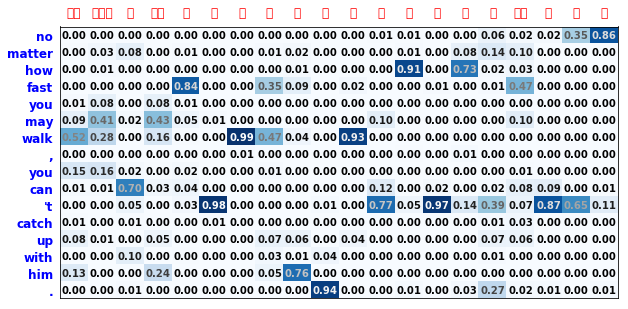

In [16]:
a = att_weights[num][:len(origx), 1:len(predy)+1]

xticks = [j_i2w[com] for com in predy]
yticks = [e_i2w[com] for com in origx]
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, aspect='equal')
ax.imshow(a, interpolation='nearest', cmap='Blues', aspect='auto', vmin=0, vmax=1)
for (_y, _x), weight in np.ndenumerate(a):
    ax.text(_x, _y, '{:.2f}'.format(weight), ha='center', va='center', color=str(weight), fontweight='bold')
ax.set_yticks(np.arange(a.shape[0]))
ax.set_xticks(np.arange(a.shape[1]))
ax.set_yticklabels(yticks, fontweight='bold', fontsize='12', color='blue')
ax.set_xticklabels(xticks, fontweight='bold', fontsize='12', color='red', fontdict={'family': 'TakaoPGothic'})
ax.xaxis.tick_top()
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
plt.show()

In [17]:
sess.close()